In [1]:
# Install
!pip install gymnasium[atari]
!pip install autorom[accept-rom-license]
!pip install torch
!pip install matplotlib
!pip install "gymnasium[other]"


[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
# Imports
import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing, FrameStackObservation
import matplotlib.pyplot as plt
import ale_py
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import time
import os

In [3]:
# Register
gym.register_envs(ale_py)

In [4]:
# DQN
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 6)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# DQN Agent
class DQNAgent:
    BATCH_SIZE = 32
    EPSILON_START = 1
    EPSILON_CUTOFF = 0.05
    EPSILON_DECAY = 0.9977 # Will take about 1000 episodes to reach 0.1 and 1300 to reach 0.05
    GAMMA = 0.99
    LR = 1e-4
    MEMORY_SIZE = 30000
    total_steps = 0

    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = DQN().to(self.device)
        self.target_net = DQN().to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.LR)
        self.memory = ReplayBuffer(self.MEMORY_SIZE)
        self.steps_done = 0
        self.epsilon = self.EPSILON_START
        self.current_episode = 0

    def select_e_greedy_action(self, env, state):
        if random.random() < self.epsilon:
            return random.randint(0, env.action_space.n - 1)
        else:
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            with torch.no_grad():
                return self.policy_net(state).argmax(dim=1).item()

    def select_greedy_action(self, state):
        state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        with torch.no_grad():
            return self.policy_net(state).argmax(dim=1).item()

    def decay_epsilon(self):
        self.total_steps += 1
        self.epsilon = max(self.EPSILON_CUTOFF, self.EPSILON_START * (self.EPSILON_DECAY ** self.current_episode))

    def step(self):
        if len(self.memory) < self.BATCH_SIZE:
            return
        batch = self.memory.sample(self.BATCH_SIZE)

        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(np.array(states), dtype=torch.float32, device=self.device)
        actions = torch.tensor(np.array(actions), dtype=torch.int64, device=self.device).unsqueeze(1)
        rewards = torch.tensor(np.array(rewards), dtype=torch.float32, device=self.device).unsqueeze(1)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32, device=self.device)
        dones = torch.tensor(np.array(dones), dtype=torch.float32, device=self.device).unsqueeze(1)
        current_q = self.policy_net(states).gather(1, actions)
        next_q = self.target_net(next_states).max(1, keepdim=True)[0].detach()
        target_q = rewards + (self.GAMMA * next_q * (1 - dones))

        loss = F.mse_loss(target_q, current_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

In [5]:
def train_q_values(env, env_name, target_update_interval=10, training_episodes=1000, agent_class=DQNAgent, checkpoint_path=None):
    agent = agent_class()
    rewards_per_episode = []
    epsilon_values = []
    episode_times = []
    start_episode = 0
    early_stop_counter = 0

    # Loading from last checkpoint
    drive_path = '/workspace/dqn_pong_checkpoints/'
    if checkpoint_path is not None:
        checkpoint = torch.load(os.path.join(drive_path, checkpoint_path))
        agent.policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
        agent.target_net.load_state_dict(checkpoint['policy_net_state_dict'])
        agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        agent.total_steps = checkpoint['total_steps']
        agent.current_episode = checkpoint['current_episode']
        rewards_per_episode = checkpoint['rewards_per_episode']
        epsilon_values = checkpoint['epsilon_values']
        episode_times = checkpoint['episode_times']
        start_episode = checkpoint['current_episode'] + 1
        agent.epsilon = max(agent.EPSILON_CUTOFF, agent.EPSILON_START * (agent.EPSILON_DECAY ** agent.current_episode))
        print(f"Resumed training from episode {start_episode}")

    for episode in range(start_episode, training_episodes):
        agent.current_episode = episode
        start_time = time.time()
        obs, _ = env.reset()
        state = obs
        total_reward = 0
        done = False
        steps_taken = 0
        episode_transitions = []

        epsilon_values.append(agent.epsilon)

        while not done:
            action = agent.select_e_greedy_action(env, state)
            obs, reward, done, _, _ = env.step(action)
            next_state = np.array(obs, dtype=np.float32)
            episode_transitions.append((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward
            steps_taken += 1

            agent.decay_epsilon()

        for transition in episode_transitions:
            agent.memory.push(*transition)

        for _ in range(len(episode_transitions)):
            agent.step()

        rewards_per_episode.append(total_reward)
        end_time = time.time()
        episode_time = end_time - start_time
        episode_times.append(episode_time)

        if total_reward >= 20:
            early_stop_counter += 1
        else:
            early_stop_counter = 0

        if early_stop_counter >= 15:
            print(f"Early stopping at episode {episode}")
            torch.save(agent.policy_net.state_dict(), os.path.join(drive_path, "dqn_pong_env_v5_early_stop_train.pth"))
            break

        if episode % 10 == 0:
            print(f"Episode {episode + 1}: Total Reward: {total_reward}, Epsilon: {agent.epsilon:.3f}, Steps: {steps_taken}, Time: {episode_time:.2f}s")
        if episode % 100 == 0:
            # Saving model
            torch.save(agent.policy_net.state_dict(), os.path.join(drive_path, "dqn_pong_env_v5.pth"))
            # Creating checkpoint dictionary
            checkpoint = {
                'policy_net_state_dict': agent.policy_net.state_dict(),
                'optimizer_state_dict': agent.optimizer.state_dict(),
                'total_steps': agent.total_steps,
                'current_episode': agent.current_episode,
                'rewards_per_episode': rewards_per_episode,
                'epsilon_values': epsilon_values,
                'episode_times': episode_times
            }
            torch.save(checkpoint, os.path.join(drive_path, "dqn_pong_checkpoints.pth"))
            print("Checkpoint Reached!")

        if episode % target_update_interval == 0:
            agent.update_target_network()

    return agent, rewards_per_episode, epsilon_values, episode_times
     

In [6]:
env_name = "PongNoFrameskip-v4"
pong_env = gym.make(env_name, render_mode="rgb_array", frameskip=1)
pong_env = AtariPreprocessing(
    pong_env,
    frame_skip=4,
    grayscale_obs=True,
    scale_obs=False,
    terminal_on_life_loss=False
)
pong_env = FrameStackObservation(pong_env, stack_size=4)

# Creating folder
drive_path = '/workspace/dqn_pong_checkpoints/'
os.makedirs(drive_path, exist_ok=True)

# Training
trained_agent, rewards_per_episode, epsilon_values, episode_times = train_q_values(pong_env, env_name, training_episodes=5000)
torch.save(trained_agent.policy_net.state_dict(), os.path.join(drive_path, "dqn_pongnoframeskip_env_v5.pth"))
     

A.L.E: Arcade Learning Environment (version 0.11.0+dfae0bd)
[Powered by Stella]


Episode 1: Total Reward: -21.0, Epsilon: 1.000, Steps: 758, Time: 4.22s
Checkpoint Reached!
Episode 11: Total Reward: -21.0, Epsilon: 0.977, Steps: 882, Time: 4.03s
Episode 21: Total Reward: -21.0, Epsilon: 0.955, Steps: 823, Time: 3.01s
Episode 31: Total Reward: -21.0, Epsilon: 0.933, Steps: 816, Time: 3.79s
Episode 41: Total Reward: -20.0, Epsilon: 0.912, Steps: 836, Time: 4.07s
Episode 51: Total Reward: -21.0, Epsilon: 0.891, Steps: 1010, Time: 3.76s
Episode 61: Total Reward: -20.0, Epsilon: 0.871, Steps: 915, Time: 4.09s
Episode 71: Total Reward: -20.0, Epsilon: 0.851, Steps: 1253, Time: 6.91s
Episode 81: Total Reward: -21.0, Epsilon: 0.832, Steps: 811, Time: 4.14s
Episode 91: Total Reward: -20.0, Epsilon: 0.813, Steps: 944, Time: 4.13s
Episode 101: Total Reward: -18.0, Epsilon: 0.794, Steps: 1186, Time: 5.48s
Checkpoint Reached!
Episode 111: Total Reward: -21.0, Epsilon: 0.776, Steps: 790, Time: 3.09s
Episode 121: Total Reward: -20.0, Epsilon: 0.759, Steps: 983, Time: 3.66s
Episod

In [7]:
np.save(os.path.join(drive_path, "rewards_per_episode_final.npy"), np.array(rewards_per_episode))
np.save(os.path.join(drive_path, "epsilon_values_final.npy"), np.array(epsilon_values))
np.save(os.path.join(drive_path, "episode_times_final.npy"), np.array(episode_times))

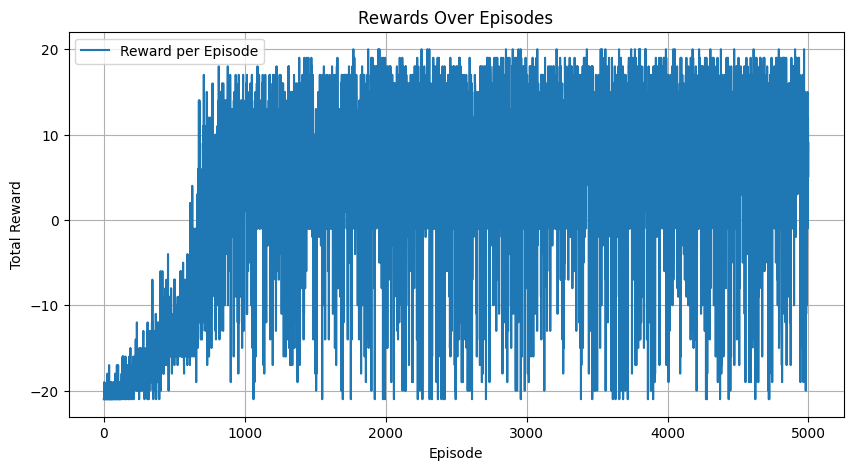

In [26]:
# Plot rewards_per_episode
plt.figure(figsize=(10, 5))
plt.plot(rewards_per_episode, label="Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Rewards Over Episodes")
plt.grid(True)
plt.legend()
plt.savefig("/workspace/dqn_pong_checkpoints/rewards_plot.png")
plt.show()

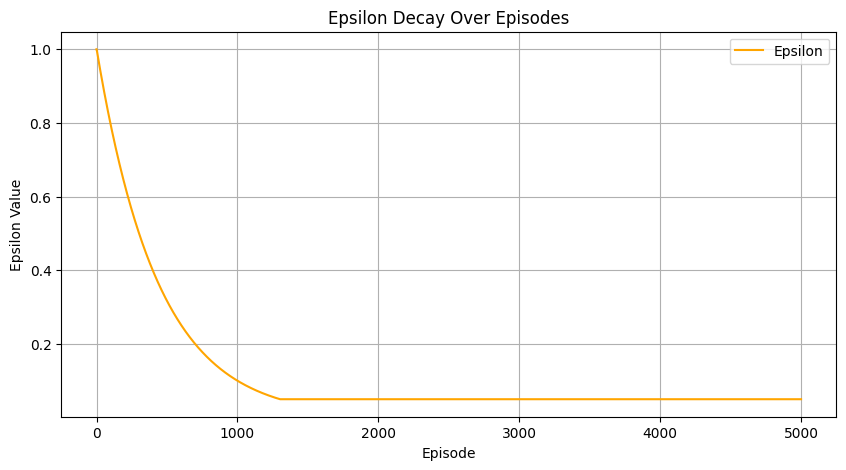

In [27]:
# Plot epsilon_values
plt.figure(figsize=(10, 5))
plt.plot(epsilon_values, label="Epsilon", color="orange")
plt.xlabel("Episode")
plt.ylabel("Epsilon Value")
plt.title("Epsilon Decay Over Episodes")
plt.grid(True)
plt.legend()
plt.savefig("/workspace/dqn_pong_checkpoints/epsilon_plot.png")
plt.show()

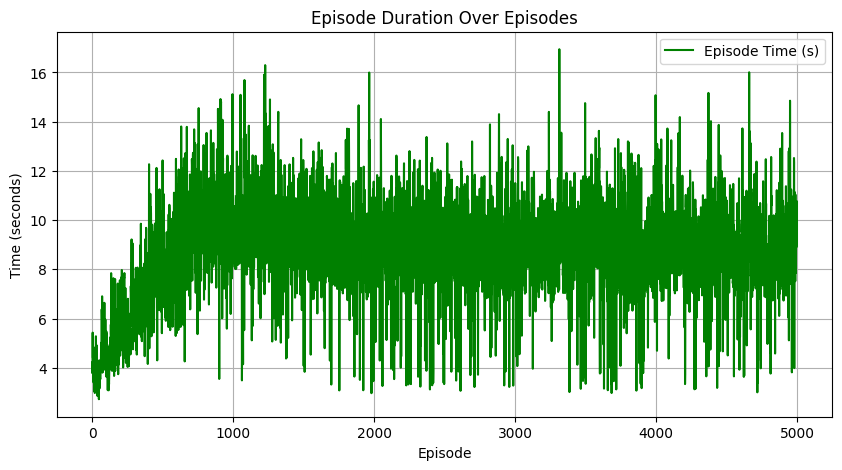

In [28]:
# Plot episode_times
plt.figure(figsize=(10, 5))
plt.plot(episode_times, label="Episode Time (s)", color="green")
plt.xlabel("Episode")
plt.ylabel("Time (seconds)")
plt.title("Episode Duration Over Episodes")
plt.grid(True)
plt.legend()
plt.savefig("/workspace/dqn_pong_checkpoints/episode_times_plot.png")
plt.show()

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DQN().to(device)
model_path = '/workspace/dqn_pong_checkpoints/dqn_pongnoframeskip_env_v5.pth'
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
model.eval()

# Evaluation
rewards_arr = []
for episode in range(10):
    obs, _ = pong_env.reset()
    state = obs
    tot_reward = 0
    done = False
    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            action = model(state_tensor).argmax(dim=1).item()
        obs, reward, done, _, _ = pong_env.step(action)
        state = np.array(obs, dtype=np.float32)
        tot_reward += reward
    rewards_arr.append(tot_reward)
    print(f"Episode {episode + 1}: Total Reward = {tot_reward}")

# Average reward
avg_reward = np.mean(rewards_arr)
print(f"\nAverage Reward over 10 episodes: {avg_reward}")

Episode 1: Total Reward = 8.0
Episode 2: Total Reward = 8.0
Episode 3: Total Reward = 20.0
Episode 4: Total Reward = 7.0
Episode 5: Total Reward = 8.0
Episode 6: Total Reward = -5.0
Episode 7: Total Reward = 20.0
Episode 8: Total Reward = -5.0
Episode 9: Total Reward = 20.0
Episode 10: Total Reward = 20.0

Average Reward over 10 episodes: 10.1


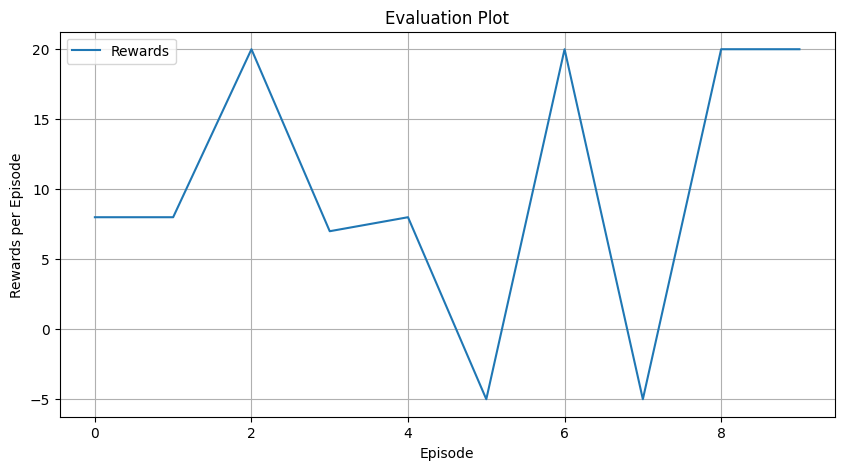

In [29]:
# Plot episode_times
plt.figure(figsize=(10, 5))
plt.plot(rewards_arr, label="Rewards")
plt.xlabel("Episode")
plt.ylabel("Rewards per Episode")
plt.title("Evaluation Plot")
plt.grid(True)
plt.legend()
plt.savefig("/workspace/dqn_pong_checkpoints/evaluation_plot.png")
plt.show()